# 外挿法による誤りの抑制

ここでは、**量子誤り抑制**の考え方と、その代表例である外挿法(Zero-Noise Extrapolation, ZNE)を紹介します。外挿法の概要を説明した後に、Qiskitを使用して、量子ダイナミクスにおけるノイズの効果を抑制できることを確認します。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{| #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 |}$
$\newcommand{\braket}[2]{\langle #1 | #2 \rangle}$

## ノイズ過程速習
量子計算の回路モデルを考える際には、状態$\rho_0$への初期化、ユニタリ演算の列$\{\mathcal{U}_l\}_{l=1}^L$、測定$\mathcal{M}$によって構成する例が多くみられます。
これらの全てが理想的に行える場合にはとてもハッピーですが、自然界に完全に孤立した系を作り出すことは難しいことから、エネルギーや位相情報の散逸が発生します（孤立量子系vs量子開放系）。
具体的には、理想的な操作を経た後の量子状態（測定直前）は

$$
\rho_0 = \mathcal{U}_L \circ \cdots \circ \mathcal{U}_1 (\rho_{\rm init})
$$

のようにかけるはずですが、実際には、$\rho_{\rm init} \rightarrow \mathcal{E}_{\rm init}(\rho_{\rm init})$、 $\mathcal{U}_l \rightarrow \mathcal{E}_l \circ \mathcal{U}_l$のように、意図しない操作に変更されます。

$$
\rho = \mathcal{E}_L \circ\mathcal{U}_L \circ \cdots \circ \mathcal{U}_1 \circ \mathcal{E}_{\rm init}(\rho_{\rm init})
$$

ここで、$\mathcal{E}_{l}$や$\mathcal{E}_{\rm init}$をそれぞれ**ゲートノイズ**や**初期化ノイズ**などと呼びます（測定ノイズもあります）。
ノイズは必ずしもユニタリ演算ではなく、それを一般化した**量子チャネル**として特徴づけることが多いです。
例えば 二つのユニタリ $U_1 \neq U_2$を確率$p_1, p_2$で実行するような操作を単一のユニタリ操作として書くことはできませんが、量子チャネルの一つとして理解ができます。

量子チャネルについて詳しく知りたい方はNielsen-Chuangの教科書などを参照してください。
以下ではKraus演算子を用いたノイズの定義は議論せず、イメージを掴むことに注力します。

### 超伝導量子ビットにおけるノイズ過程

超伝導量子ビットでは、主に次の2つの緩和過程が問題となります。

- **T1 緩和（エネルギー緩和）**
  量子ビットが励起状態（|1⟩）から基底状態（|0⟩）へエネルギーを失いながら遷移する過程を表します。$T_1$ はこのエネルギー緩和にかかる平均時間を示します。
  ある1量子ビットゲートにかかる時間が$t$の時、確率$p=1-e^{-t/T_1}$で$|1\rangle \rightarrow |0\rangle$の遷移を起こす操作としてモデル化されています。

- **T2 緩和（位相緩和、デコヒーレンス）**
  量子状態の位相情報が失われる過程で、$T_2$ は位相コヒーレンスが保たれる時間の尺度です。一般に、$T_2$ は $T_1$ より短くなる傾向があります（理想的には $T_2 \leq 2T_1$）。
  量子力学では相対位相が重要であることを考えると、この過程は $|1\rangle$状態の位相が乱される過程と見なすことができます。
  ある1量子ビットゲートにかかる時間が$t$の時、確率$p=1-e^{-t/T_2}$で$|1\rangle \rightarrow -|1\rangle$の遷移を起こすものとしてモデル化されます。

### 具体例：ラビ振動とノイズ

ラビ振動は、外部からの駆動（例えば、マイクロ波パルス）により二準位系（qubit）が周期的に遷移する現象です。
理想状態では、Bloch ベクトルは Bloch 球上を滑らかに回転しますが、T1 や T2 による緩和（ノイズ）の影響で、振動は減衰し、最終的には定常状態に落ち着きます。

具体的に、初期状態を $|0\rangle$にとり、Rabi振動を考えます。具体的には,

$$
|\psi(\theta)\rangle = R_y(2\theta) |0\rangle = \cos \theta |0\rangle + \sin \theta |1\rangle
$$

のような時間発展を考えます。ここで、 $R_y(\theta) = e^{i Y \theta} = \begin{pmatrix}\cos \theta & -\sin \theta \\ \sin \theta & \cos \theta \end{pmatrix}$はパウリY演算子に関する回転演算子として定義されています。
この時の量子状態の期待値は、理想的には

$$
\langle \psi(\theta) | Z | \psi(\theta) \rangle = \cos \theta,
\langle \psi(\theta) | X | \psi(\theta) \rangle = \sin \theta,
\langle \psi(\theta) | Y | \psi(\theta) \rangle = 0
$$

のように与えられます。

[練習]これを確かめてください。

回転角$\theta$を大きくするにつれて、ゲートの実行時間が長くなるため、ノイズの影響を大きく受けるようになります。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix, Operator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error

# 緩和時間の設定
T1 = 100e-6      # T1 緩和時間 [s]
T2 = 80e-6       # T2 緩和時間 [s]

def simulate_bloch(angles, variable_gate_time=False, base_gate_time=1e-6):
    """
    各 Ry 回転角度に対する Bloch ベクトルの期待値をシミュレーションする関数。

    variable_gate_time が True の場合、各角度に応じたゲート実行時間を用いてノイズをシミュレートします。

    パラメータ:
      angles (array): Ry 回転角度のリスト
      variable_gate_time (bool): ゲート時間を角度に比例させるか否か
      base_gate_time (float): 2π の回転に対応するゲート実行時間 [s]

    戻り値:
      x_vals, y_vals, z_vals (list): 各角度における Bloch ベクトルの期待値
    """
    x_vals, y_vals, z_vals = [], [], []

    for theta in angles:
        qc = QuantumCircuit(1)
        qc.ry(theta, 0)

        if variable_gate_time:
            # 回転角 theta に比例したゲート時間を計算
            current_gate_time = base_gate_time * (theta / (2*np.pi))
            # 現在のゲート時間に合わせたノイズモデルを作成
            current_noise_model = NoiseModel()
            current_error = thermal_relaxation_error(T1, T2, current_gate_time)
            current_noise_model.add_all_qubit_quantum_error(current_error, ['ry'])
            backend = AerSimulator(noise_model=current_noise_model)
            qc.save_density_matrix()
        else:
            backend = AerSimulator()  # 理想シミュレーション（ノイズなし）
            qc.save_statevector()

        compiled_qc = transpile(qc, backend)
        result = backend.run(compiled_qc).result()

        opX = Operator.from_label('X')
        opY = Operator.from_label('Y')
        opZ = Operator.from_label('Z')

        if variable_gate_time:
            rho = result.data(0)['density_matrix']
            dm = DensityMatrix(rho)
            expX = np.real(dm.expectation_value(opX))
            expY = np.real(dm.expectation_value(opY))
            expZ = np.real(dm.expectation_value(opZ))
        else:
            state = result.data(0)['statevector']
            sv = Statevector(state)
            expX = np.real(sv.expectation_value(opX))
            expY = np.real(sv.expectation_value(opY))
            expZ = np.real(sv.expectation_value(opZ))

        x_vals.append(expX)
        y_vals.append(expY)
        z_vals.append(expZ)

    return x_vals, y_vals, z_vals

In [2]:
# 回転角度の設定：0 ～ 2π
angles = np.linspace(0, 16*np.pi, 200)

# 理想シミュレーション（ノイズなし）
ideal_x, ideal_y, ideal_z = simulate_bloch(angles, variable_gate_time=False)

# ノイズありシミュレーション：ゲート時間を角度に比例させる (今回は2piのためのゲート時間を10usと長く設定、通常は 10nsオーダー)
noisy_x, noisy_y, noisy_z = simulate_bloch(angles, variable_gate_time=True, base_gate_time=10e-6)

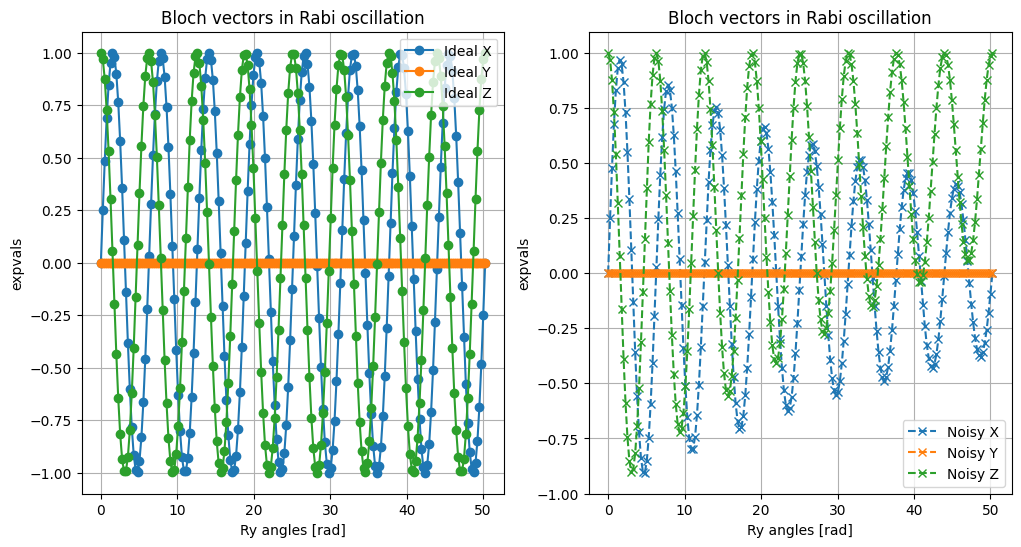

In [3]:
# プロット

import matplotlib
#matplotlib.rcParams['font.family'] = 'AppleGothic'

fig = plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(angles, ideal_x, label='Ideal X', marker='o')
plt.plot(angles, ideal_y, label='Ideal Y', marker='o')
plt.plot(angles, ideal_z, label='Ideal Z', marker='o')
plt.xlabel('Ry angles [rad]')
plt.ylabel('expvals')
plt.title('Bloch vectors in Rabi oscillation')
plt.legend()
plt.grid(True)
#plt.show()


plt.subplot(1,2,2)
plt.plot(angles, noisy_x, '--', label='Noisy X', marker='x', color = "C0")
plt.plot(angles, noisy_y, '--', label='Noisy Y', marker='x', color = "C1")
plt.plot(angles, noisy_z, '--', label='Noisy Z', marker='x', color = "C2")

plt.xlabel('Ry angles [rad]')
plt.ylabel('expvals')
plt.title('Bloch vectors in Rabi oscillation')
plt.legend()
plt.grid(True)
#plt.show()

## 量子誤り抑制
上で見たようなエラーの影響があると、正しい量子計算が実行できません。対策として、大雑把には以下の二つが考えられています。
- 量子誤り抑制 : 実行時間の増大と引き換えに精度を上げる方法
- 量子誤り訂正 : 量子ビット数の増大と引き換えに精度を上げる方法

ここでは量子誤り抑制の代表として知られる、**外挿法(Zero-noise extrapolation, ZNE)** を説明し、上のラビ振動において効果を検証します。

## 外挿法による誤り抑制
ある量子ビットでRabi振動のシグナルを改善したいとします。もしT1, T2時間を10倍長くできれば、もちろんノイズの影響は圧倒的に小さくなるが、デバイスレベルの改善には大きな労力が伴います。
逆に、シグナルを悪化させることはできるでしょうか？もし系統的にシグナルを悪化させることができれば、それらの情報を集めてノイズのない状況の振る舞いを予想できるのではないか、というのが外挿法のアイディアです。


もう少し具体的に考えてみます。
$R_y(\theta) |0\rangle$という状態を生成する際に、T1,T2緩和によって$p_1=1-e^{-t/T_1}, p_2=1-e^{-t/T_2}$程度の大きさのエラーが生じるが、これをまとめて$p=(p_1,p_2)$のように表すことにします。
さらに、生成された量子状態における物理量$O$の期待値を$\langle O(p)\rangle$と書くことにします。

ここで、わざと$2t$の時間をかけて同じ操作をすることを考えます。この時、$t\ll T_1, T_2$であれば、エラーの大きさは$2p$まで増幅され、量子状態の期待値は$\langle O(2p)\rangle$に対応するものになります。
求めたい真の期待値はエラーがゼロの極限に対応するものであるから、$O_{\rm est} = 2\langle O(p)\rangle - \langle O(2p)\rangle$のように推定する、というのが外挿法です。

上の係数は、Richardson extrapolationに基づいて決定されています。具体的に、ある関数$f(\lambda)$について、二つの非負の値$\lambda_1, \lambda_2$における値$f(\lambda_1), f(\lambda_2)$を知っていたと仮定しましょう。ここで、関数が

$$
f(\lambda) = f(0) + c\lambda
$$

のように線形近似できると仮定すると、$f$を用いた推定に関する二乗誤差を最小化することによって以下が求まります。

$$
f(0) = \frac{\lambda_2 f(\lambda_1) - \lambda_1 f(\lambda_2)}{\lambda_2 - \lambda_1}.
$$

これに$\lambda_1 = 1, \lambda_2 = 2$を代入すると、上の表式が出てきます。

同様な考え方により、$\{O(\lambda p)\}_{\lambda>1}$のように、パラメータ$\lambda$に関する期待値の集合を用いた外挿法が実行できます。

[練習] 上の$f(0)$の式を導きましょう。

[発展] 3点以上の点が得られた場合にはどのような推定が行われるでしょうか(Richardson外挿)

In [4]:
# ノイズありシミュレーション：ゲート時間を角度に比例させる (今回は2piのためのゲート時間を10usと長く設定、通常は 10nsオーダー)
noisy_x_2, noisy_y_2, noisy_z_2 = simulate_bloch(angles, variable_gate_time=True, base_gate_time=20e-6)
noisy_x_3, noisy_y_3, noisy_z_3 = simulate_bloch(angles, variable_gate_time=True, base_gate_time=30e-6)

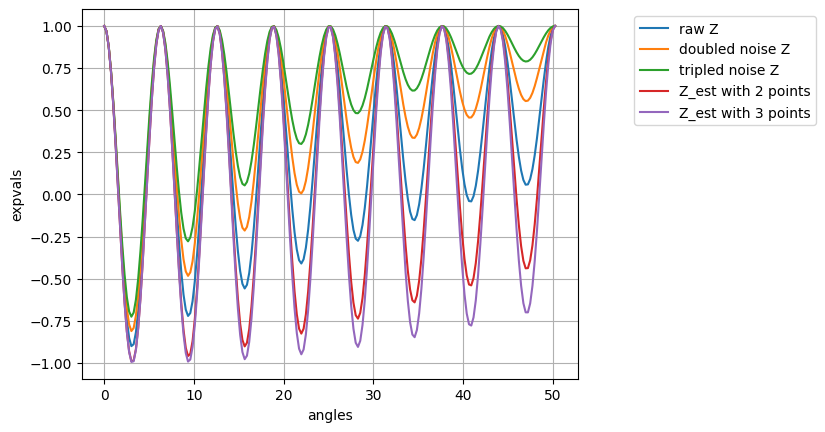

In [5]:
# 2点を使って 多項式外挿
x_est2 = 2 * np.array(noisy_x) - np.array(noisy_x_2)
y_est2 = 2 * np.array(noisy_y) - np.array(noisy_y_2)
z_est2 = 2 * np.array(noisy_z) - np.array(noisy_z_2)

# 3点を使って 多項式外挿
x_est3 = 3 * np.array(noisy_x) - 3 * np.array(noisy_x_2) + np.array(noisy_x_3)
y_est3 = 3 * np.array(noisy_y) - 3 * np.array(noisy_y_2) + np.array(noisy_y_3)
z_est3 = 3 * np.array(noisy_z) - 3 * np.array(noisy_z_2) + np.array(noisy_z_3)

plt.plot(angles, noisy_z, label = "raw Z")
plt.plot(angles, noisy_z_2, label = "doubled noise Z")
plt.plot(angles, noisy_z_3, label = "tripled noise Z")
plt.plot(angles, z_est2, label = "Z_est with 2 points")
plt.plot(angles, z_est3, label = "Z_est with 3 points")

plt.legend(bbox_to_anchor=(1.1, 1))

plt.xlabel("angles")
plt.ylabel("expvals")
plt.grid()

## 外挿法による分散の増大

ここまでの結果を見ると、外挿法でエラーを削減できることがわかりました。
ただし、外挿法をはじめとする量子エラー抑制手法は、期待値のバイアスを小さくする代わりに、代償として推定の分散が大きくなってしまいます。
例えば、$O_{\rm est} = 2 \langle O(p) \rangle - \langle O(2p)\rangle$のように推定を行うとき、それぞれの推定の分散が$\sigma_{p}^2, \sigma_{2p}^2$とすると、$O_{\rm est}$の分散$\sigma_{\rm est}^2$は

$$
\sigma_{\rm est}^2 = 2^2 \sigma_p^2 + \sigma_{2p}^2
$$

に従います。同様に、$p$, $2p$, $3p$の3点を用いた場合には

$$
\sigma_{\rm est}^2 = 3^2 \sigma_p^2 + 3^2\sigma_{2p}^2 + \sigma_{3p}^2
$$

となります。多くの点を用いて推定精度を上げれば、Richardson補間における多項式の係数の値は大きくなるため、分散も大きくなります。

例えば、パウリ演算子の固有状態に関する射影測定を通じて期待値を推定する場合には、分散と測定回数$M$の間には $\sigma^2 \propto 1/M$の関係式があります。
そのため、分散が4倍, 9倍と大きくなる場合には、測定回数を2倍, 3倍する必要があることがわかります。

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error

# システムパラメータ
T1 = 100e-6      # T1 緩和時間 [s]
T2 = 80e-6       # T2 緩和時間 [s]
shots = 1024     # 測定ショット数

# projective measurement による評価用シミュレーション関数
def simulate_projective(angles, variable_gate_time, base_gate_time, shots=1024):
    """
    各角度に対して、Ry 回転とその後の Z 基底での projective measurement を行い、
    ショット数による評価結果（期待値と標準誤差）を返す関数。

    パラメータ:
      angles: 0 ～ 2π の回転角度の配列
      variable_gate_time: True の場合、各角度に比例してゲート時間を延ばす
      base_gate_time: 2π の回転に対応するゲート時間 [s]（スケーリング係数 r=1 の場合）
      shots: 測定ショット数
    戻り値:
      f_vals: 各角度における Z 期待値 (f = (#0 - #1)/shots)
      f_errs: その標準誤差 (2*sqrt(p*(1-p)/shots), ただし p = #0/shots)
    """
    f_vals = []
    f_errs = []

    for theta in angles:
        # 1 qubit, 1 classical bitの回路を作成
        qc = QuantumCircuit(1, 1)
        qc.ry(theta, 0)
        qc.measure(0, 0)

        # variable_gate_time が True の場合、各角度でゲート時間を調整
        if variable_gate_time:
            # 現在の Ry ゲートの実行時間: θ/(2π) * base_gate_time
            current_gate_time = base_gate_time * (theta / (2*np.pi))
            # ノイズモデルの作成
            noise_model = NoiseModel()
            error = thermal_relaxation_error(T1, T2, current_gate_time)
            noise_model.add_all_qubit_quantum_error(error, ['ry'])
            backend = AerSimulator(noise_model=noise_model, shots=shots)
        else:
            backend = AerSimulator(shots=shots)

        compiled_qc = transpile(qc, backend)
        result = backend.run(compiled_qc).result()
        counts = result.get_counts(qc)
        # カウント取得：'0' は Z=+1, '1' は Z=-1 として扱う
        count0 = counts.get('0', 0)
        count1 = counts.get('1', 0)
        f_val = (count0 - count1) / shots
        # p = 確率 (0の出現確率)
        p = count0 / shots
        # 標準誤差：二項分布に基づく誤差 2*sqrt(p*(1-p)/shots)
        f_err = 2 * np.sqrt(p * (1-p) / shots)
        f_vals.append(f_val)
        f_errs.append(f_err)

    return np.array(f_vals), np.array(f_errs)

# 0～2π の回転角度
angles = np.linspace(0, 12*np.pi, 200)

# ノイズスケーリングによるシミュレーション
# r=1: base_gate_time = 10 μs, r=2: 20 μs, r=3: 30 μs
proj_z_1, err_1 = simulate_projective(angles, variable_gate_time=True, base_gate_time=10e-6, shots=shots)
proj_z_2, err_2 = simulate_projective(angles, variable_gate_time=True, base_gate_time=20e-6, shots=shots)
proj_z_3, err_3 = simulate_projective(angles, variable_gate_time=True, base_gate_time=30e-6, shots=shots)

# ---------- Richardson extrapolationによる ZNE ----------
rich_z_2 = 2 * proj_z_1 - proj_z_2
rich_err_2 = np.sqrt((2 * err_1)**2 + (err_2)**2) # 誤差: σ² = (2σ₁)² + (2σ₂)²

rich_z_3 = 3 * proj_z_1 - 3 * proj_z_2 + proj_z_3
rich_err_3 = np.sqrt((3 * err_1)**2 + (3 * err_2)**2 + (err_3)**2) # 誤差: σ² = (3σ₁)² + (3σ₂)² + (σ₃)²

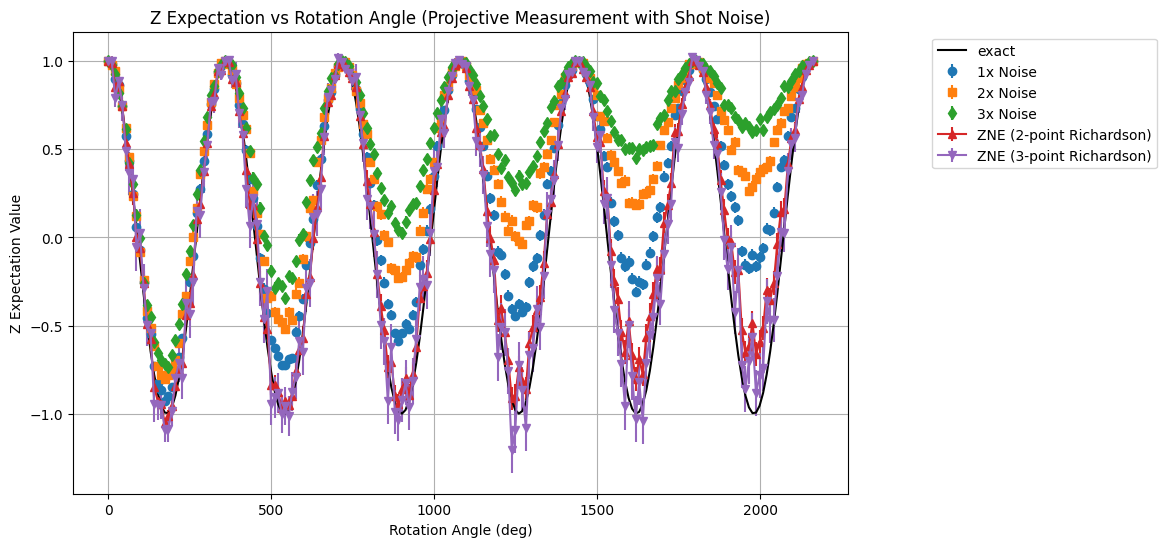

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
angles_deg = np.degrees(angles)

ax.errorbar(angles_deg, proj_z_1, yerr=err_1, fmt='o', label='1x Noise')
ax.errorbar(angles_deg, proj_z_2, yerr=err_2, fmt='s', label='2x Noise')
ax.errorbar(angles_deg, proj_z_3, yerr=err_3, fmt='d', label='3x Noise')

ax.errorbar(angles_deg, rich_z_2, yerr=rich_err_2, fmt='^-', label='ZNE (2-point Richardson)')
ax.errorbar(angles_deg, rich_z_3, yerr=rich_err_3, fmt='v-', label='ZNE (3-point Richardson)')

ax.plot(angles_deg, np.cos(angles_deg/360 * 2 * np.pi), "-", color = "black", label = "exact")

ax.set_xlabel('Rotation Angle (deg)')
ax.set_ylabel('Z Expectation Value')
ax.set_title('Z Expectation vs Rotation Angle (Projective Measurement with Shot Noise)')
ax.legend(bbox_to_anchor = (1.1, 1))
ax.grid()
#plt.show()

Text(0, 0.5, 'frequency')

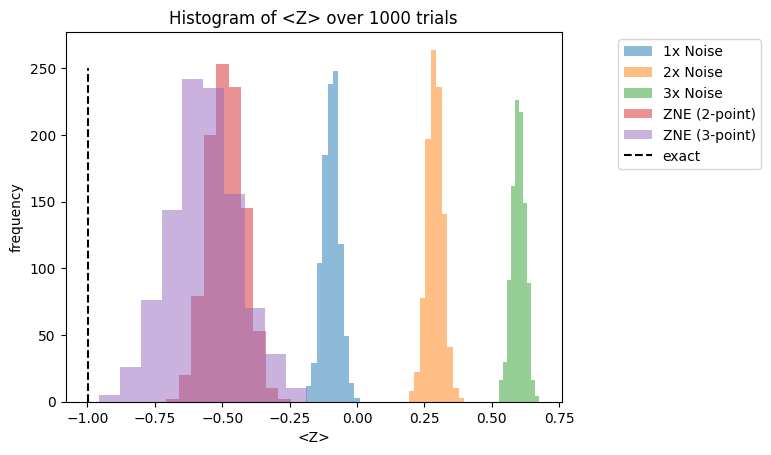

In [8]:
idx = -18

labels = ["1x Noise", "2x Noise", "3x Noise", "ZNE (2-point)", "ZNE (3-point)"]

for k, (means, stds) in enumerate(zip([proj_z_1, proj_z_2, proj_z_3, rich_z_2, rich_z_3], [err_1, err_2, err_3, rich_err_2, rich_err_3])):

    plt.hist(np.random.normal(loc=means[idx], scale = stds[idx], size = 1000), label = labels[k], alpha  =0.5)

plt.vlines(x = np.cos(angles_deg[idx]/360 * np.pi * 2), ymin = 0, ymax = 250, label = "exact", linestyle = "--", color = "black")


plt.legend(bbox_to_anchor = (1.1, 1))

plt.title("Histogram of <Z> over 1000 trials")
plt.xlabel("<Z>")
plt.ylabel("frequency")